# Ranking Feature Importance With Random Forest and Logistic Regression

### Information About Dataset
* Any 9 in the dataset represents Nan
* Feature PSys is the target class 
* 1 in column PSys means the nation is peaceful
* 2 in column PSys means the nation is not peaceful

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns


# function that loads csv
def load_peace_sys_data():
    df = pd.DataFrame(pd.read_csv('peace_sys.csv', index_col=0, na_values=['(NA)']))
    return df

# Data Loading and Overview

In [78]:
# loading the dataset
peace_sys = load_peace_sys_data()

peace_sys.head()    

SCCS   Coder ID1.1Over ID1.2Ethno Int2.1Mar Int2.2Econ Int2.3Pol  \
Name                                                                            
Gilbertese    107      KA         9          2         3          9         9   
Marshallese   108      EC         1          9         9          1         9   
E. Pomo       135  KA, EC         9          9         9          9         9   
Popoluca      154      KA         9          3         9          3         9   
Konso          35      KA         9          2         3          4         9   

            Int2.4Hist Dep3.1Sec Dep3.2Ecol  ... CM8.5Peace CM8.6War Lead9.1P  \
Name                                         ...                                
Gilbertese           9         9          9  ...          9        9        9   
Marshallese          9         9          9  ...          9        2        9   
E. Pomo              9         1          1  ...          9        9        2   
Popoluca             9         9          3  ...          9        9        9   
Konso                4         9          2  ...          9        9        9   

            Lead9.2War Cult10.1Com Cult10.2Diff Comp10.3 InComp10.4 PSys  \
Name                                                                       
Gilbertese           9           9            9        9          9    2   
Marshallese          4           9            9        9          9    2   
E. Pomo              9           9            9        9          9    2   
Popoluca             9           9            9        9          9    2   
Konso                9           3            9        3          3    2   

            CMoverall  
Name                   
Gilbertese          9  
Marshallese         2  
E. Pomo             2  
Popoluca            9  
Konso               9  

[5 rows x 36 columns]

In [79]:
peace_sys = peace_sys.drop(['SCCS','Coder','CMoverall'], axis=1)
peace_sys

ID1.1Over ID1.2Ethno Int2.1Mar Int2.2Econ Int2.3Pol Int2.4Hist  \
Name                                                                          
Gilbertese           9          2         3          9         9          9   
Marshallese          1          9         9          1         9          9   
E. Pomo              9          9         9          9         9          9   
Popoluca             9          3         9          3         9          9   
Konso                9          2         3          4         9          4   
Bribri               9          2         2          9         9          9   
Tallensi             1          2         4          9         1          3   
Russians             4          9         1          9         9          9   
Trukese              3          9         4          4         3          9   
Toraja               1          9         1          1         9          9   
Pawnee               3          3         9          3         9          3   
Rhade                9          4         2          9         9          9   
Burmese              9          2         9          2         9          9   
Timbira              9          2         2          9         9          2   
Basseri              2          3         3          4         4          9   
Havasupai            2          9         2          4         9          3   
Yukaghir             3          3         1          2         9          9   
Comanche             3          4         2          9         3          9   
Jivaro               1          4         1          4         1          1   
Yanomamo             9          9         9          9         9          9   
Burusho              9          2         9          1         9          2   
Taureg               1          9         2          9         2          9   
Shavante             2          3         9          2         1          1   
Kurds                9          9         9          9         9          9   
Yapese               9          9         9          9         9          9   
Teda                 1          4         3          2         2          9   
Vietnamese           2          9         9          3         9          3   
Kikuyu               2          9         2          2         9          9   
Omaha                9          3         9          9         2          9   
Natchez              9          9         1          1         1          1   
Switzerland          3          3         9          9         2          4   
Iroquois           3.5        2.5         3        3.5         4          4   
Orang Asli           2          2         2          2         1          3   
Nilgiri Pla.         2          3         1          4         2          4   
Wynaad Pla.          3          2         2          4         9          3   
Nordic Nats.         4          1         3          4         4          4   
Up Xingu RB          4          2         4          4         1          9   
W. Australia         4          2         4          2         9          4   
Mon-Naskapi          2          2         9          4         9          3   
Italy                2          3         9          3         2          2   
So Cone              3          9         9          4         4          9   
Netherlands          4          2         9          4         4          4   
USA                  4          2         3          4         4          3   
Mbuti                                                                         
Juhoansi             2          9         4          3         1          3   
Germany                                                                       
Lephcha                                                                       
Kogi                                                                          

             Dep3.1Sec Dep3.2Ecol Dep3.3Econ NWVal4.1  ... CM8

In [80]:
# remove nations that are not classified
peace_sys = peace_sys[peace_sys.PSys != ' ']

# replace empty spaces and 9's with NaN
peace_sys = peace_sys.replace('9', np.nan)
peace_sys = peace_sys.replace(' ', np.nan)

In [81]:
# Changing every data point to float
cols = peace_sys.columns
peace_sys[cols] = peace_sys[cols].apply(pd.to_numeric)

In [82]:
print(f'There are {peace_sys.isnull().any().sum()} columns in train dataset with missing values.')

There are 32 columns in train dataset with missing values.


# Data Exploration

Text(0.5, 1.0, 'Distibution of PSys variable')

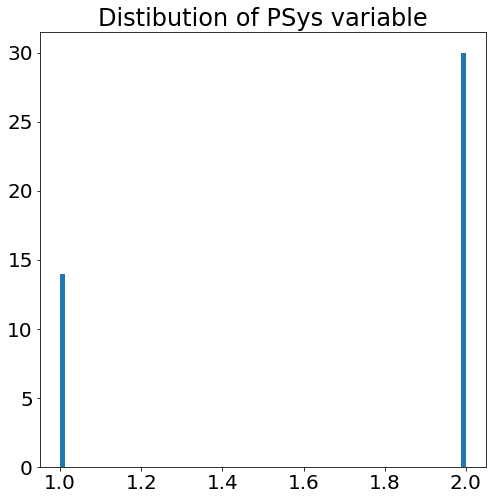

In [83]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.hist(peace_sys['PSys'], bins=77)
plt.title('Distibution of PSys variable')

The feature **PSys** is our target class. We can see that there is a **class imbalance** in the dataset. There is twice as many nations that are categorized as '2' than '1'. In an attempt to fix this we will later apply **SMOTE** to the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127007910>,
      dtype=object)

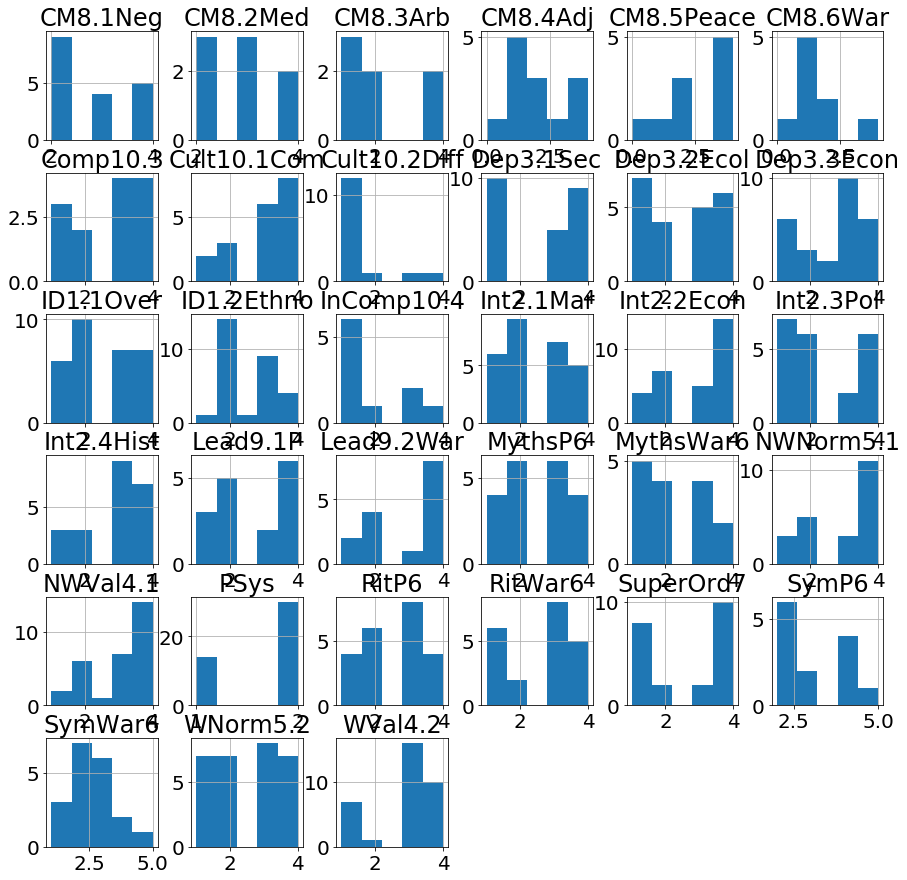

In [84]:
plt.rcParams['figure.figsize'] = (15, 15)
peace_sys.hist(bins=5)

# Cleaning Dataset

In [85]:
peace_sys.fillna(0.0, inplace=True)

### Implementing SMOTE to dataset
SMOTE (synthetic minority oversampling technique) works by finding two near neighbours in a minority class, producing a new point midway between the two existing points and adding that new point in to the sample. The example shown is in two dimensions, but SMOTE will work across multiple dimensions (features). SMOTE therefore helps to ‘fill in’ the feature space occupied by minority classes.

In [86]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27, sampling_strategy='minority')

In [87]:
y = peace_sys.PSys
X = peace_sys.drop('PSys', axis=1)

### Generating Training and Test Set

In [88]:
# generating train_set and test_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)


# Random Forest

In [89]:
rfc = RandomForestClassifier(n_estimators=2000).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

### Performance

In [90]:
print('Accuracy: ', accuracy_score(y_test, rfc_pred))
print('F1 Score: ', f1_score(y_test, rfc_pred, average='weighted'))
print('Recall Score: ', recall_score(y_test, rfc_pred, average='weighted'))

Accuracy:  0.9375
F1 Score:  0.9353864734299517
Recall Score:  0.9375


### Confusion Matrix
|   |P  |N  |
|---|---|---|
|P  |TP |FN |
|N  |FP |TN | 


In [91]:
# Using a confusion matrix we can evaluate the performance of the model
# The fundamental of confusion matrix is the number of correct and incorrect
# predictions are summed up class-wise
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, rfc_pred)

cnf_matrix

array([[ 4,  1],
       [ 0, 11]])

# Feature Importance For Random Forest

In [92]:
rfc_importances = rfc.feature_importances_
rfc_indices = np.argsort(rfc_importances)[::-1]


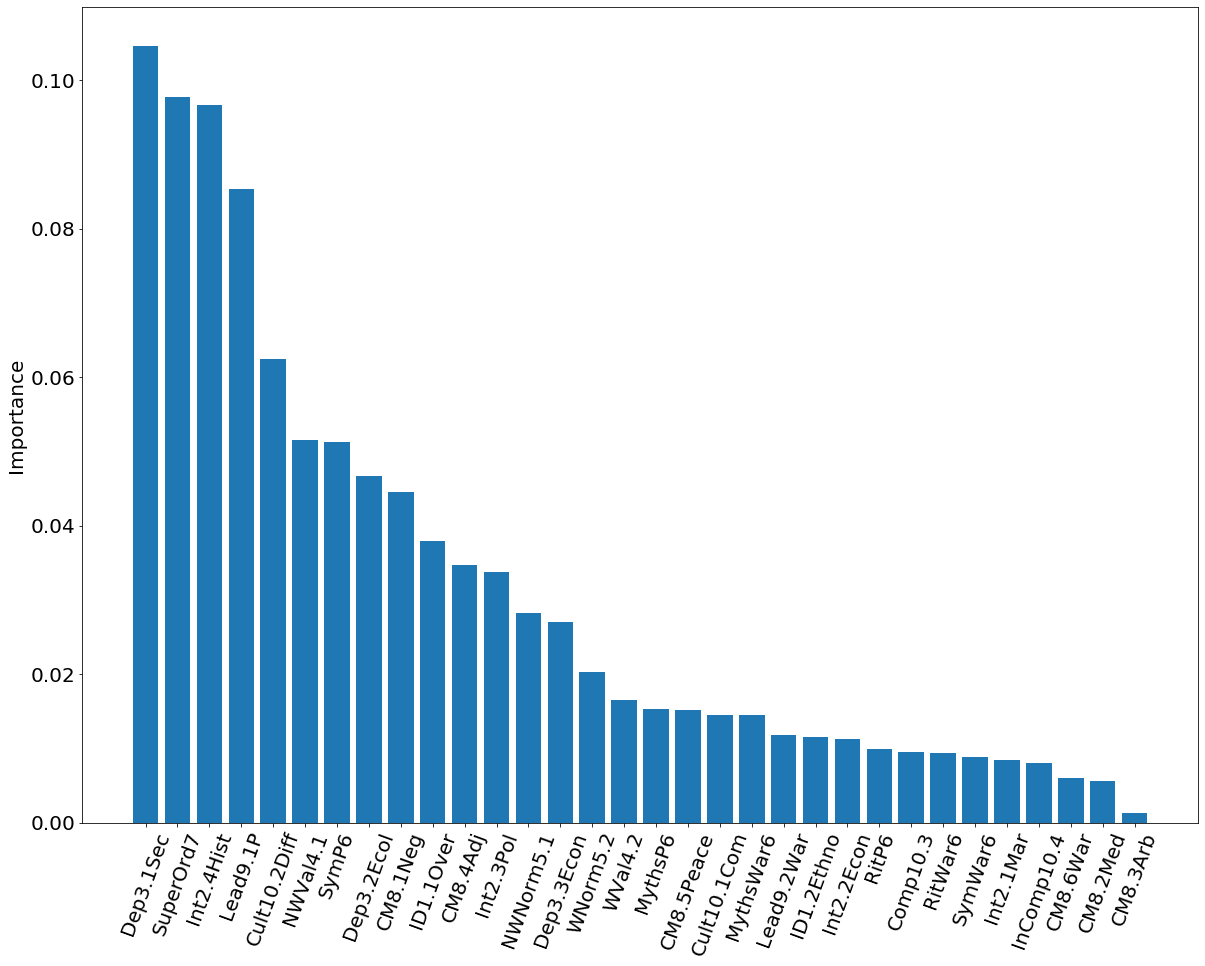

In [93]:
plt.subplots(figsize=(20,15))
plt.bar(range(X.shape[1]), rfc_importances[rfc_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[rfc_indices], rotation=70)
plt.ylabel('Importance')
plt.show()

# Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
logreg_pred = logreg.predict(X_test)

In [97]:
print('Accuracy: ', accuracy_score(y_test, logreg_pred))
print('F1 Score: ', f1_score(y_test, logreg_pred, average='weighted'))
print('Recall Score: ', recall_score(y_test, logreg_pred, average='weighted'))

Accuracy:  0.875
F1 Score:  0.8645833333333333
Recall Score:  0.875


In [98]:
cnf_matrix = metrics.confusion_matrix(y_test, logreg_pred)

cnf_matrix

array([[ 3,  2],
       [ 0, 11]])

# Feature Importance For Logistic Regression

In [99]:
logreg_importances = np.abs(logreg.coef_[0])
logreg_indices = np.argsort(logreg_importances)[::-1]

<Figure size 1080x1080 with 0 Axes>

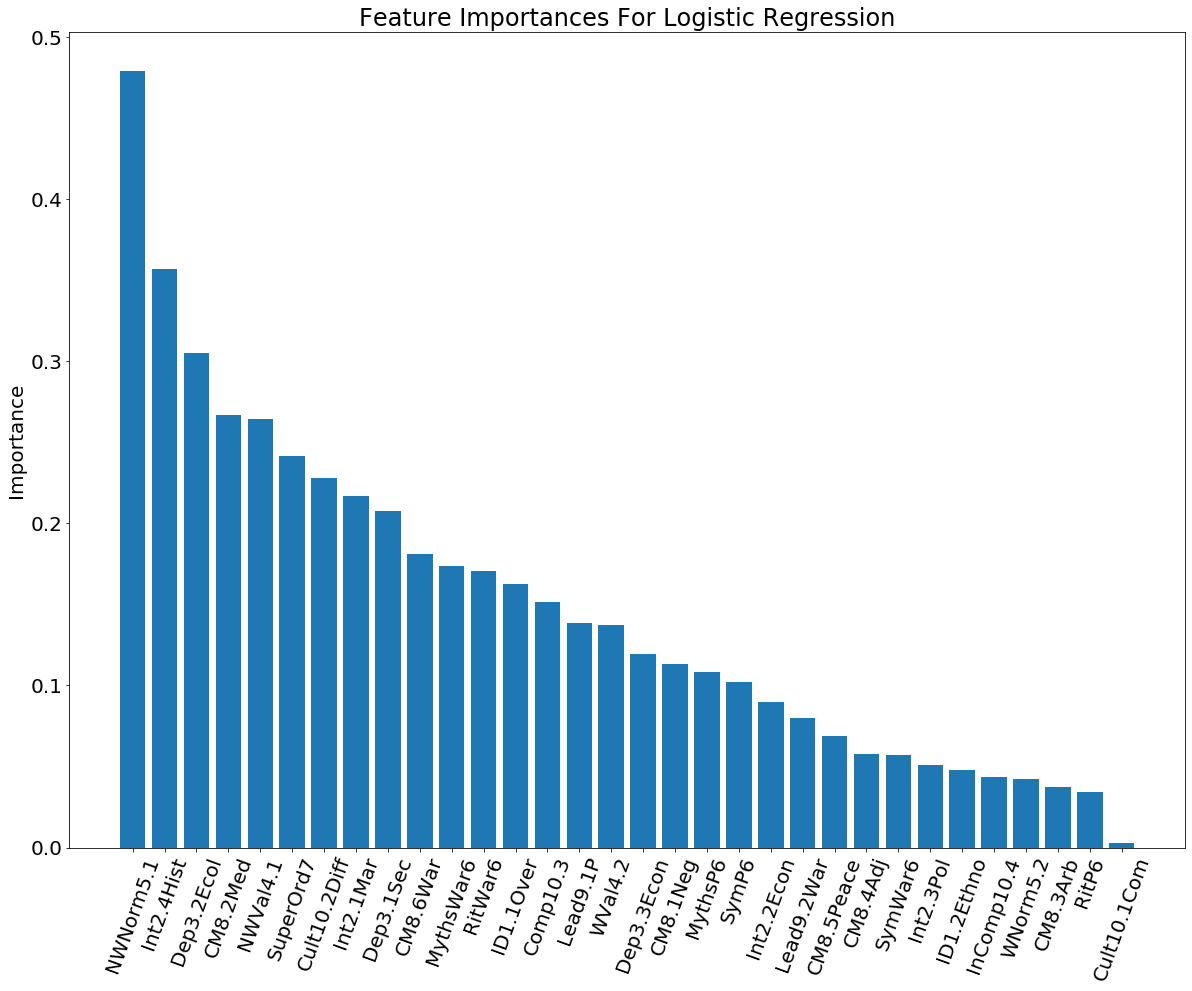

In [100]:
plt.figure()
plt.subplots(figsize=(20,15))
plt.title('Feature Importances For Logistic Regression')
plt.bar(range(X.shape[1]), logreg_importances[logreg_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[logreg_indices], rotation = 70)
plt.ylabel('Importance')
plt.show()

# Comparing Random Forest and Logistic Regression Rankings

In [101]:
importances = pd.DataFrame.from_dict({'Random_Forest' : rfc_indices, 'Logistic_Regression' :  logreg_indices}, orient='index')

importances

0   1   2   3   4   5   6   7   8   9   ...  22  23  24  \
Random_Forest         6  19   5  26  29   9  17   7  20   0  ...   3  15  30   
Logistic_Regression  11   5   7  21   9  19  29   2   6  25  ...  24  23  18   

                     25  26  27  28  29  30  31  
Random_Forest        16  18   2  31  25  21  22  
Logistic_Regression   4   1  31  12  22  15  28  

[2 rows x 32 columns]

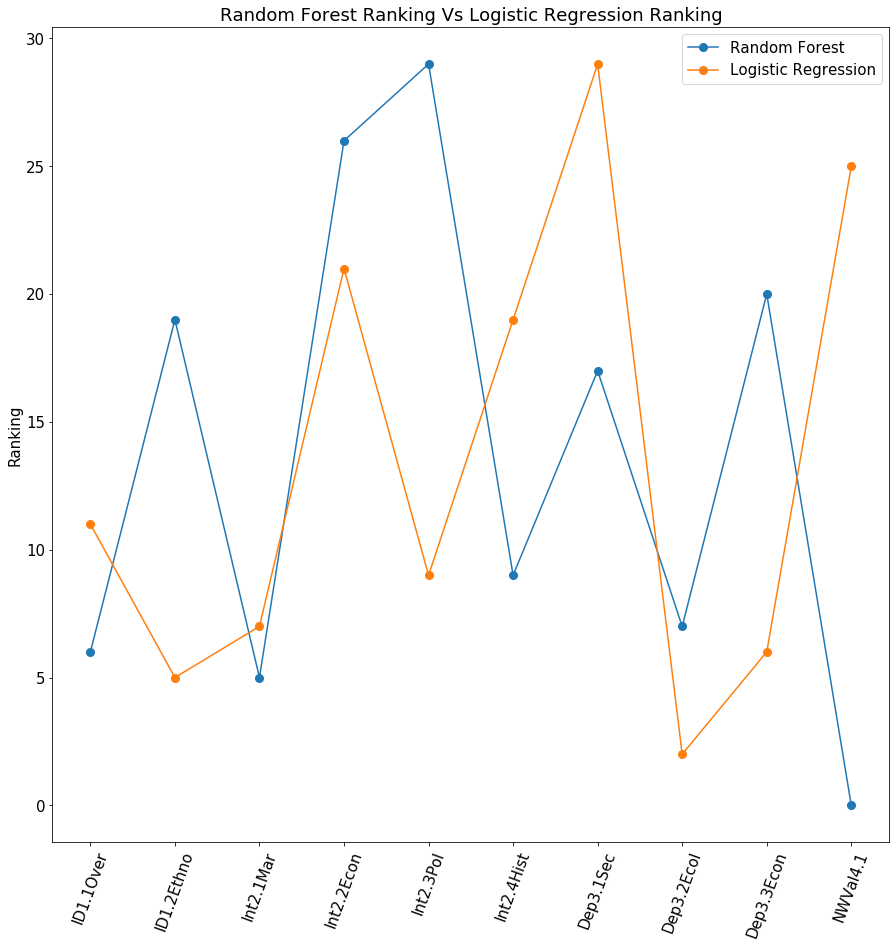

In [102]:
plt.figure()
plt.rcParams.update({'font.size' : 15})
plt.title('Random Forest Ranking Vs Logistic Regression Ranking')
plt.plot(X.columns[:10], importances.T[:10], marker='o' ,markersize=8)
plt.xticks(rotation=70)
plt.ylabel('Ranking')
plt.legend(['Random Forest', 'Logistic Regression'])
plt.show()

# Normalizing Data

In [103]:
rfc_cum_dist = []
logreg_cum_dist = []

# cumulative distribution of Random Forest Importances
for i in range(len(rfc_importances)):
    cum_dist = rfc_importances[i]
    for j in range(i + 1, len(rfc_importances) - 1):
        cum_dist += rfc_importances[j]
    rfc_cum_dist.append(cum_dist)

# cumulative distribution of Logistic Regression Importances
for i in range(len(logreg_importances)):
    cum_dist = logreg_importances[i]
    for j in range(i + 1, len(logreg_importances) - 1):
        cum_dist += logreg_importances[j]
    logreg_cum_dist.append(cum_dist)   

In [104]:
A = rfc_cum_dist[0]
for i in range(len(rfc_cum_dist)):
    rfc_cum_dist[i] = rfc_cum_dist[i] / A

A = logreg_cum_dist[0]
for i in range(len(logreg_cum_dist)):
    logreg_cum_dist[i] = logreg_cum_dist[i] / A

In [105]:
product_of_distributions = []
sum_of_distributions = []

for i in range(len(rfc_cum_dist)):
    product_of_distributions.append(rfc_cum_dist[i] * logreg_cum_dist[i])
    sum_of_distributions.append(rfc_cum_dist[i] + logreg_cum_dist[i])

In [106]:
dist_df = pd.DataFrame.from_dict({'Product' : product_of_distributions, 'Sum' : sum_of_distributions})

<Figure size 1080x1080 with 0 Axes>

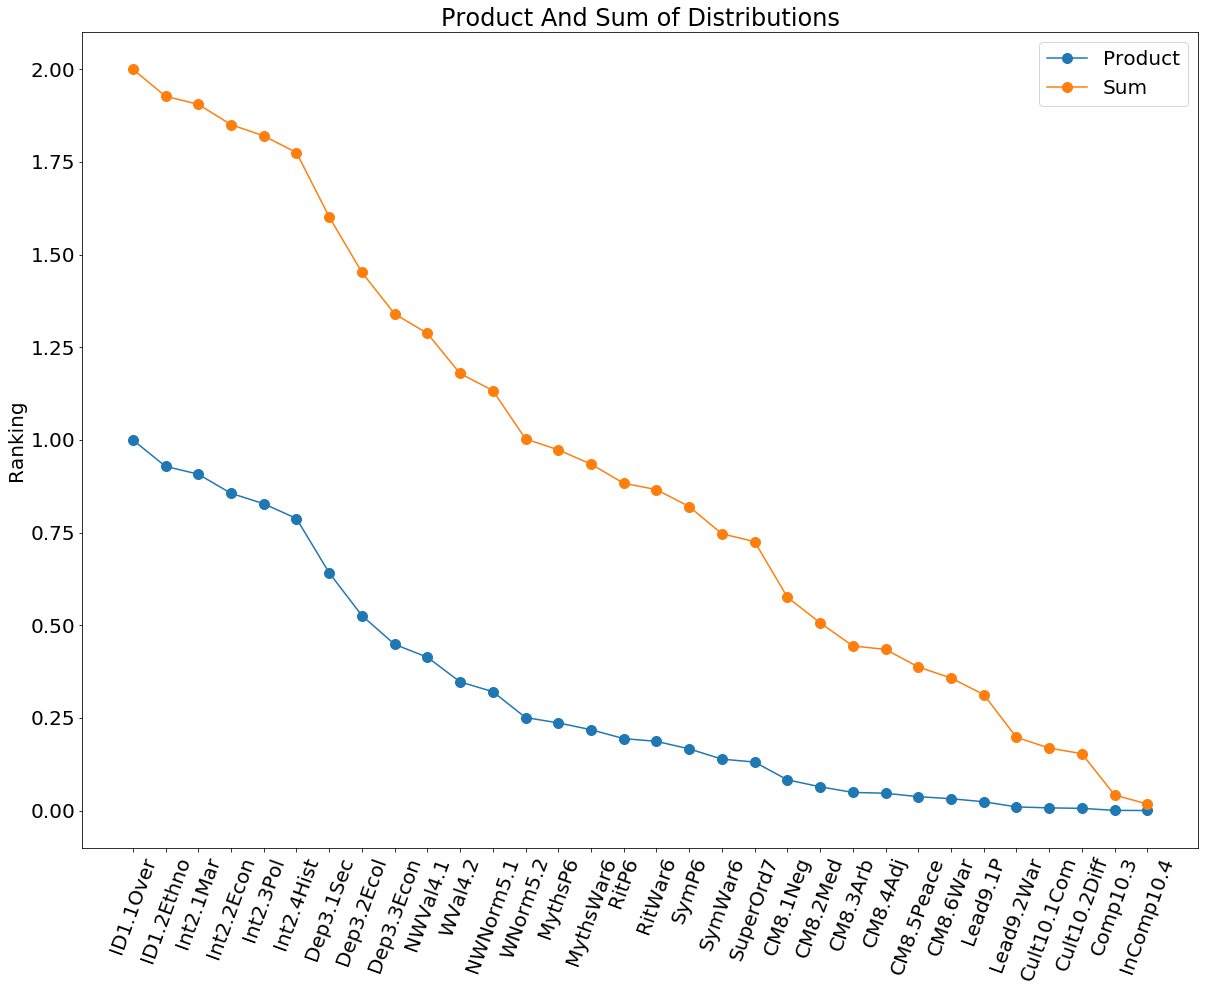

In [107]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.subplots(figsize=(20,15))
plt.title('Product And Sum of Distributions')
plt.plot(X.columns, dist_df, marker='o' ,markersize=10)
plt.xticks(rotation=70)
plt.ylabel('Ranking')
plt.legend(['Product', 'Sum'])
plt.show()

In [108]:
importances_df = pd.DataFrame.from_dict({'Random Forest' : rfc_importances, 'Logistic Regression' : logreg_importances})
importances_norm = (importances_df - importances_df.mean()) / (importances_df.max() - importances_df.min())

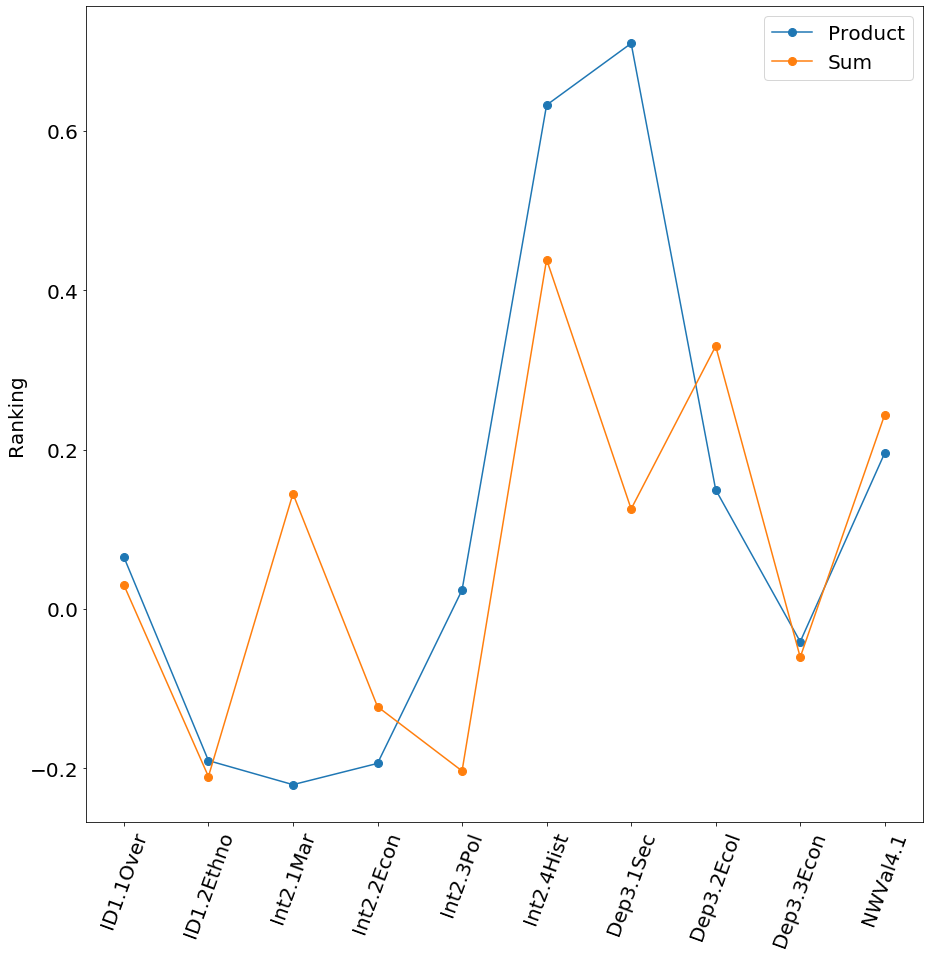

In [109]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.title('')
plt.plot(X.columns[:10], importances_norm[:10], marker='o' ,markersize=8)
plt.xticks(rotation=70)
plt.ylabel('Ranking')
plt.legend(['Product', 'Sum'])
plt.show()

In [110]:
sum_of_importances = []

for i in range(len(rfc_importances)):
    sum_of_importances.append(rfc_importances[i] + logreg_importances[i])

sorted_indices_sum = np.argsort(sum_of_importances)[::-1]

sum_importances_df = pd.DataFrame.from_dict({'Random Forest' : rfc_importances[sorted_indices_sum], 'Logistic Regression' : logreg_importances[sorted_indices_sum]})

# Ranking Features Base On Sum Of Scores

<Figure size 1080x1080 with 0 Axes>

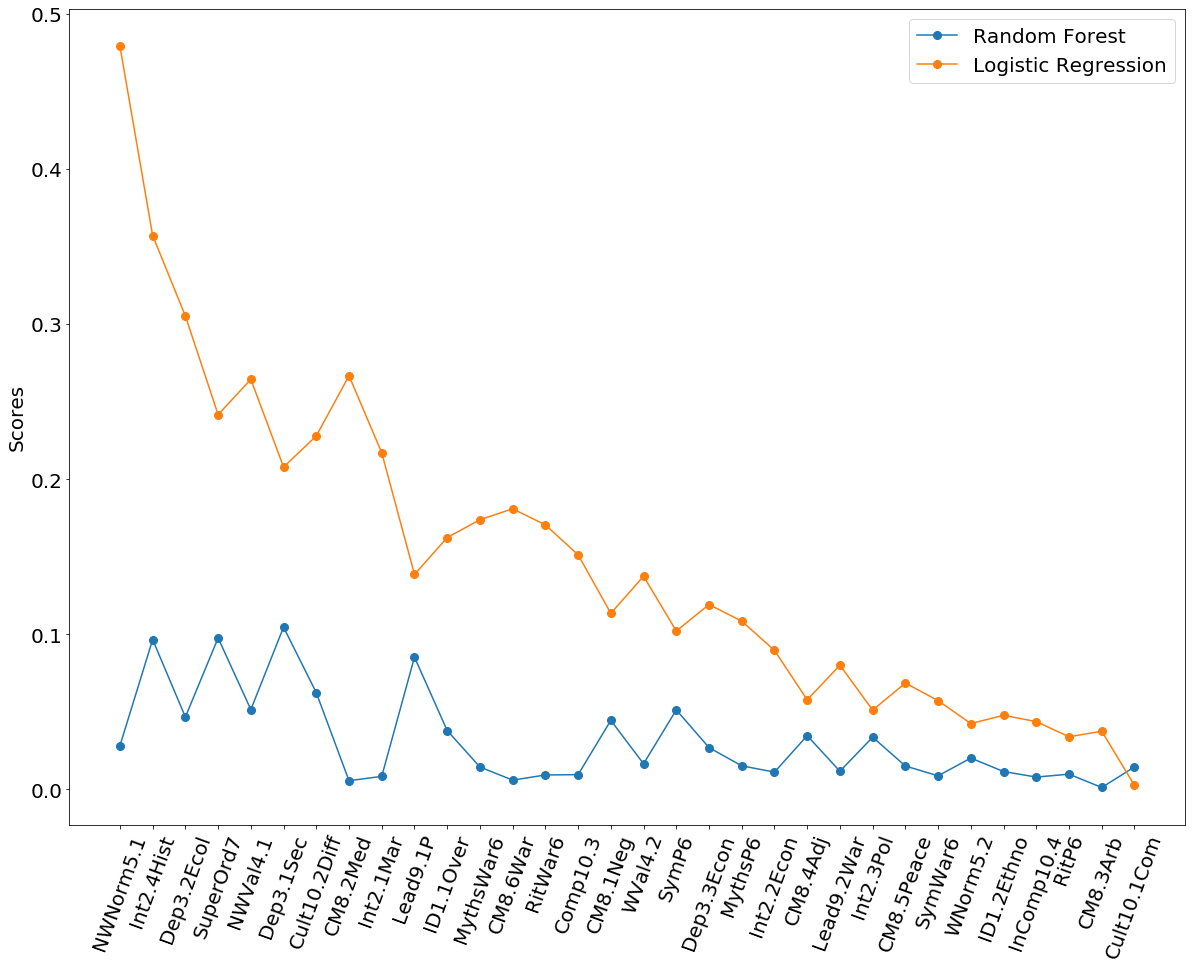

In [111]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.subplots(figsize=(20,15))
plt.title('')
plt.plot(sum_importances_df, marker='o' ,markersize=8)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_sum],rotation=70)
plt.ylabel('Scores')
plt.legend(['Random Forest', 'Logistic Regression'])
plt.show()

# Ranking Features Based On Product Of Scores

In [112]:
product_of_importances = []

for i in range(len(rfc_importances)):
    product_of_importances.append(rfc_importances[i] * logreg_importances[i])

sorted_indices_product = np.argsort(product_of_importances)[::-1]
product_importances_df = pd.DataFrame.from_dict({'Random Forest' : rfc_importances[sorted_indices_product], 'Logistic Regression' : logreg_importances[sorted_indices_product]})



<Figure size 1080x1080 with 0 Axes>

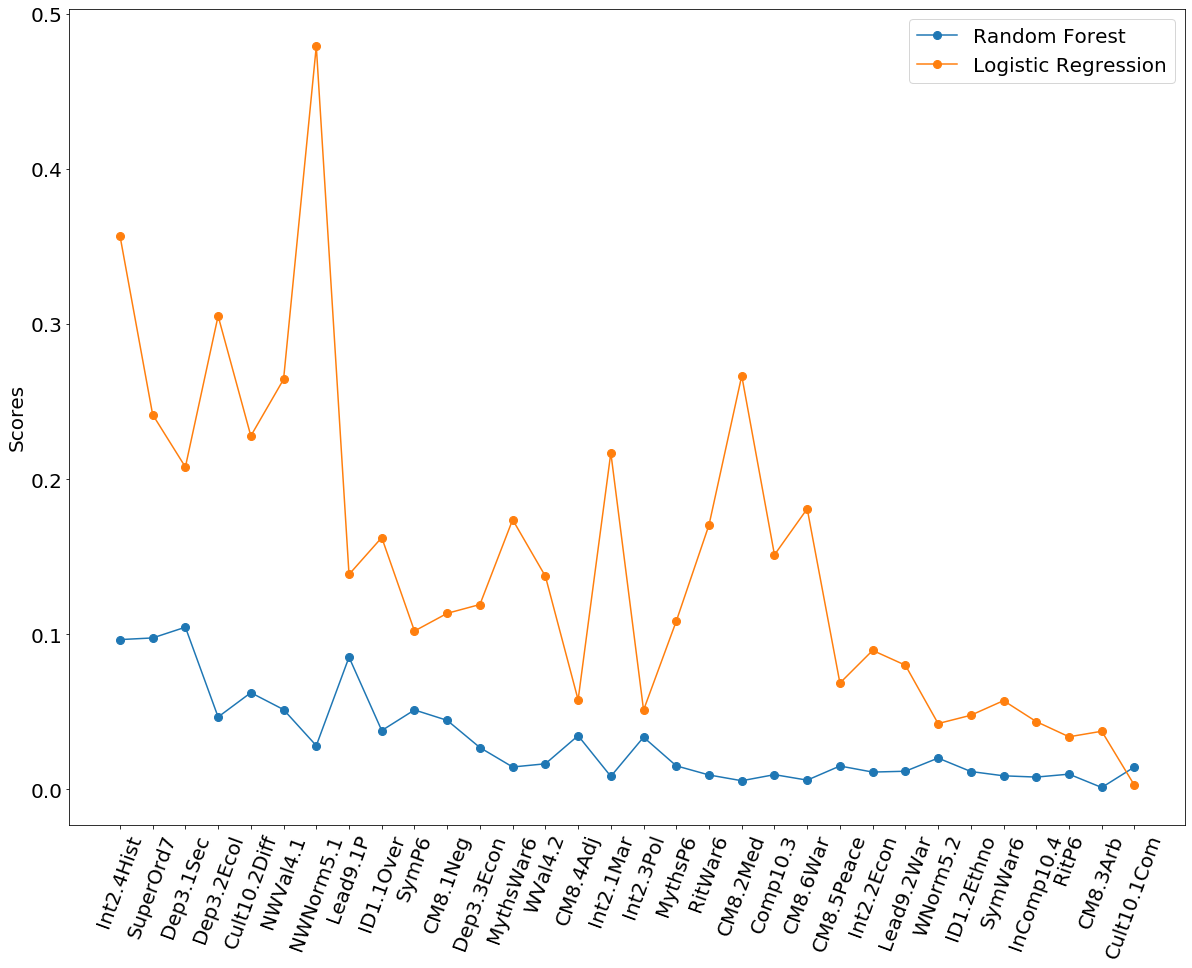

In [113]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.subplots(figsize=(20,15))
plt.title('')
plt.plot(product_importances_df, marker='o' ,markersize=8)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_product],rotation=70)
plt.ylabel('Scores')
plt.legend(['Random Forest', 'Logistic Regression'])
plt.show()

In [114]:
product_sum_ranking_df = pd.DataFrame.from_dict({'Product' : X.columns[sorted_indices_product], 'Sum' : X.columns[sorted_indices_sum]})

In [115]:
product_sum_ranking_cvs = product_sum_ranking_df.to_csv('product_sum_ranking.csv', header=True)
product_sum_ranking_df

Product           Sum
0     Int2.4Hist     NWNorm5.1
1      SuperOrd7    Int2.4Hist
2      Dep3.1Sec    Dep3.2Ecol
3     Dep3.2Ecol     SuperOrd7
4   Cult10.2Diff      NWVal4.1
5       NWVal4.1     Dep3.1Sec
6      NWNorm5.1  Cult10.2Diff
7       Lead9.1P      CM8.2Med
8      ID1.1Over     Int2.1Mar
9          SymP6      Lead9.1P
10      CM8.1Neg     ID1.1Over
11    Dep3.3Econ     MythsWar6
12     MythsWar6      CM8.6War
13       WVal4.2       RitWar6
14      CM8.4Adj      Comp10.3
15     Int2.1Mar      CM8.1Neg
16     Int2.3Pol       WVal4.2
17       MythsP6         SymP6
18       RitWar6    Dep3.3Econ
19      CM8.2Med       MythsP6
20      Comp10.3    Int2.2Econ
21      CM8.6War      CM8.4Adj
22    CM8.5Peace    Lead9.2War
23    Int2.2Econ     Int2.3Pol
24    Lead9.2War    CM8.5Peace
25      WNorm5.2       SymWar6
26    ID1.2Ethno      WNorm5.2
27       SymWar6    ID1.2Ethno
28    InComp10.4    InComp10.4
29         RitP6         RitP6
30      CM8.3Arb      CM8.3Arb
31   Cult10.1Com   Cult10.1Com

# Finding the Probability For Each Feature

In [116]:
sum_of_rfc_importances = np.sum(rfc_importances) 
sum_of_logreg_importances = np.sum(logreg_importances)

In [117]:
proba_of_rfc_importances = []
for res in rfc_importances:
    proba_of_rfc_importances.append(res / sum_of_rfc_importances)

In [118]:
proba_of_logreg_importances = []
for res in logreg_importances:
    proba_of_logreg_importances.append(res / sum_of_logreg_importances)

In [119]:
sum_of_probas = []
for i in range(len(proba_of_rfc_importances)):
    sum_of_probas.append(proba_of_rfc_importances[i] + proba_of_logreg_importances[i])

sorted_indices_proba_sum = np.argsort(sum_of_probas)[::-1]

proba_importances_sum_df = pd.DataFrame.from_dict({'Random Forest' : np.array(proba_of_rfc_importances)[sorted_indices_proba_sum], 'Logistic Regression' : np.array(proba_of_logreg_importances)[sorted_indices_proba_sum]})


<Figure size 1080x1080 with 0 Axes>

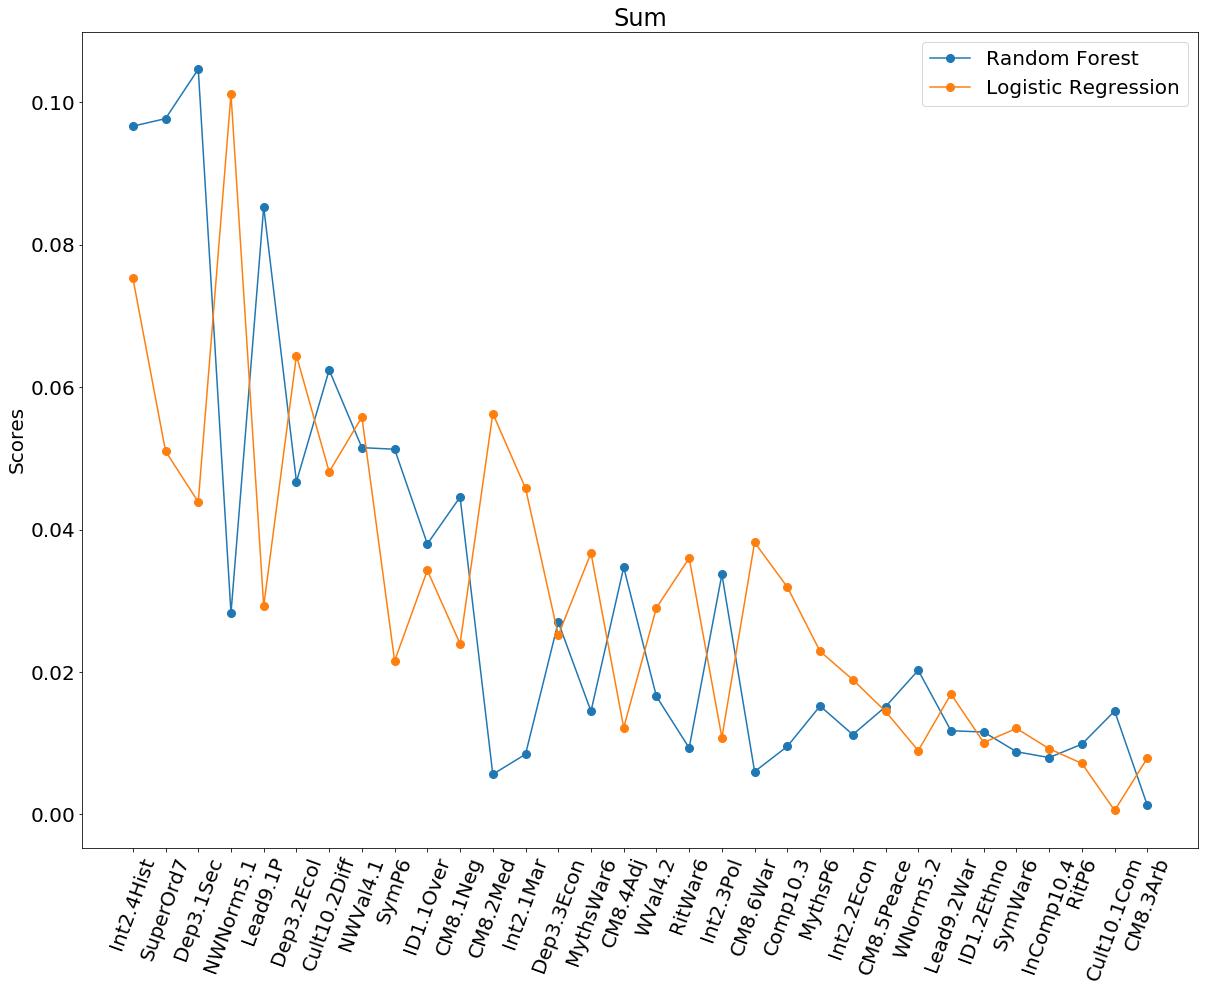

In [120]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.subplots(figsize=(20,15))
plt.title('Sum')
plt.plot(proba_importances_sum_df, marker='o' ,markersize=8)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_proba_sum],rotation=70)
plt.ylabel('Scores')
plt.legend(['Random Forest', 'Logistic Regression'])
plt.show()

In [121]:
product_of_probas = []
for i in range(len(proba_of_rfc_importances)):
    product_of_probas.append(proba_of_rfc_importances[i] * proba_of_logreg_importances[i])

sorted_indices_proba_product = np.argsort(product_of_probas)[::-1]

proba_importances_product_df = pd.DataFrame.from_dict({'Random Forest' : np.array(proba_of_rfc_importances)[sorted_indices_proba_product], 'Logistic Regression' : np.array(proba_of_logreg_importances)[sorted_indices_proba_product]})



<Figure size 1080x1080 with 0 Axes>

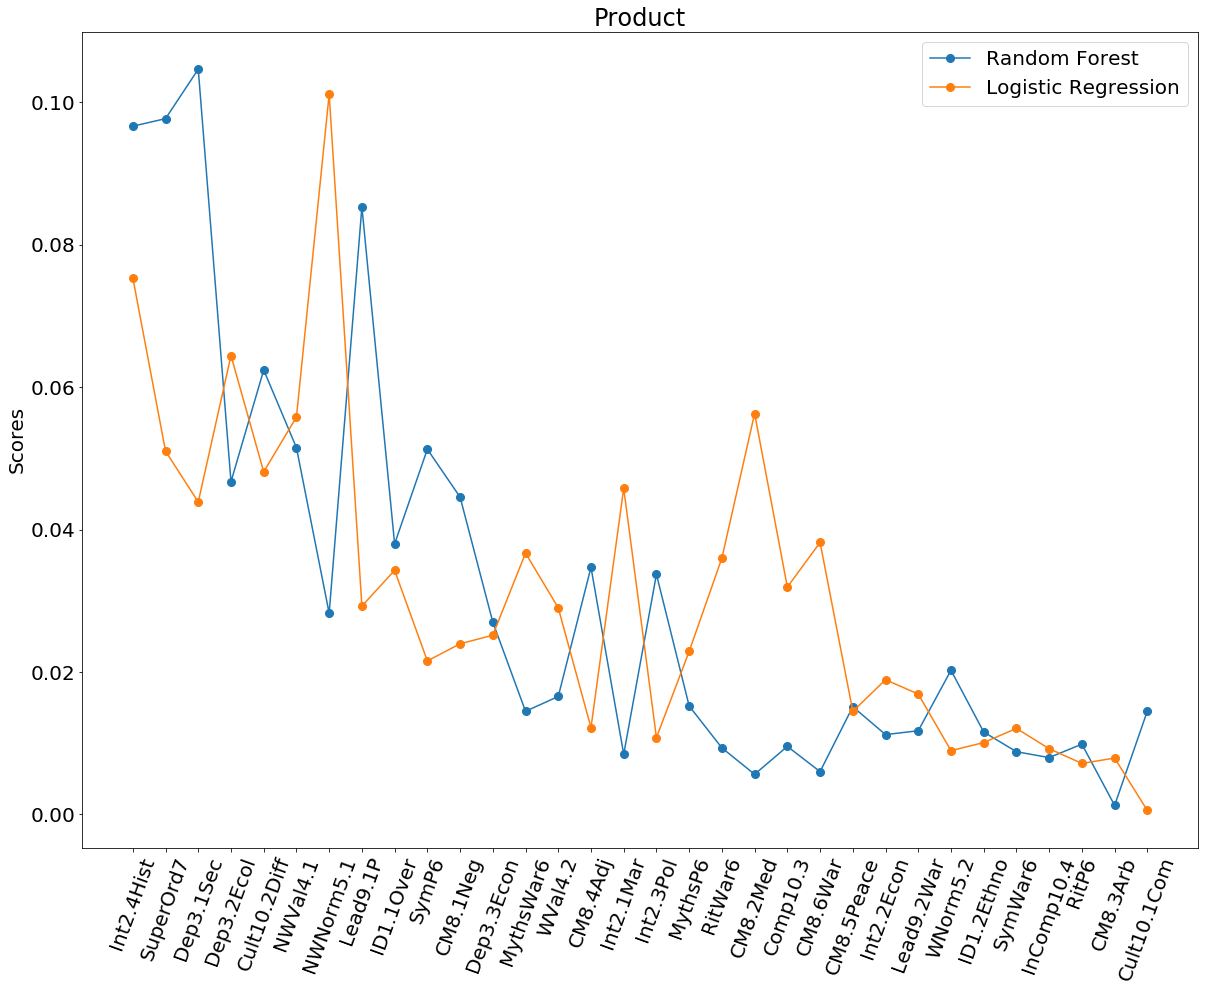

In [122]:
plt.figure()
plt.rcParams.update({'font.size' : 20})
plt.subplots(figsize=(20,15))
plt.title('Product')
plt.plot(proba_importances_product_df, marker='o' ,markersize=8)
plt.xticks(range(X.shape[1]), X.columns[sorted_indices_proba_product],rotation=70)
plt.ylabel('Scores')
plt.legend(['Random Forest', 'Logistic Regression'])
plt.show()

In [123]:
proba_sum_product_ranking_df = pd.DataFrame.from_dict({'Product' : X.columns[sorted_indices_proba_product], 'Sum' : X.columns[sorted_indices_proba_sum]})

proba_sum_product_ranking_cvs = proba_sum_product_ranking_df.to_csv('proba_sum_product_ranking.csv', header=True)
proba_sum_product_ranking_df


Product           Sum
0     Int2.4Hist    Int2.4Hist
1      SuperOrd7     SuperOrd7
2      Dep3.1Sec     Dep3.1Sec
3     Dep3.2Ecol     NWNorm5.1
4   Cult10.2Diff      Lead9.1P
5       NWVal4.1    Dep3.2Ecol
6      NWNorm5.1  Cult10.2Diff
7       Lead9.1P      NWVal4.1
8      ID1.1Over         SymP6
9          SymP6     ID1.1Over
10      CM8.1Neg      CM8.1Neg
11    Dep3.3Econ      CM8.2Med
12     MythsWar6     Int2.1Mar
13       WVal4.2    Dep3.3Econ
14      CM8.4Adj     MythsWar6
15     Int2.1Mar      CM8.4Adj
16     Int2.3Pol       WVal4.2
17       MythsP6       RitWar6
18       RitWar6     Int2.3Pol
19      CM8.2Med      CM8.6War
20      Comp10.3      Comp10.3
21      CM8.6War       MythsP6
22    CM8.5Peace    Int2.2Econ
23    Int2.2Econ    CM8.5Peace
24    Lead9.2War      WNorm5.2
25      WNorm5.2    Lead9.2War
26    ID1.2Ethno    ID1.2Ethno
27       SymWar6       SymWar6
28    InComp10.4    InComp10.4
29         RitP6         RitP6
30      CM8.3Arb   Cult10.1Com
31   Cult10.1Com      CM8.3Arb

## Heat Map for (sum_of_proba + product_of_proba)
* X axis : ranking for sum
* Y axis : ranking for product

In [124]:

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<function matplotlib.pyplot.show(*args, **kw)>

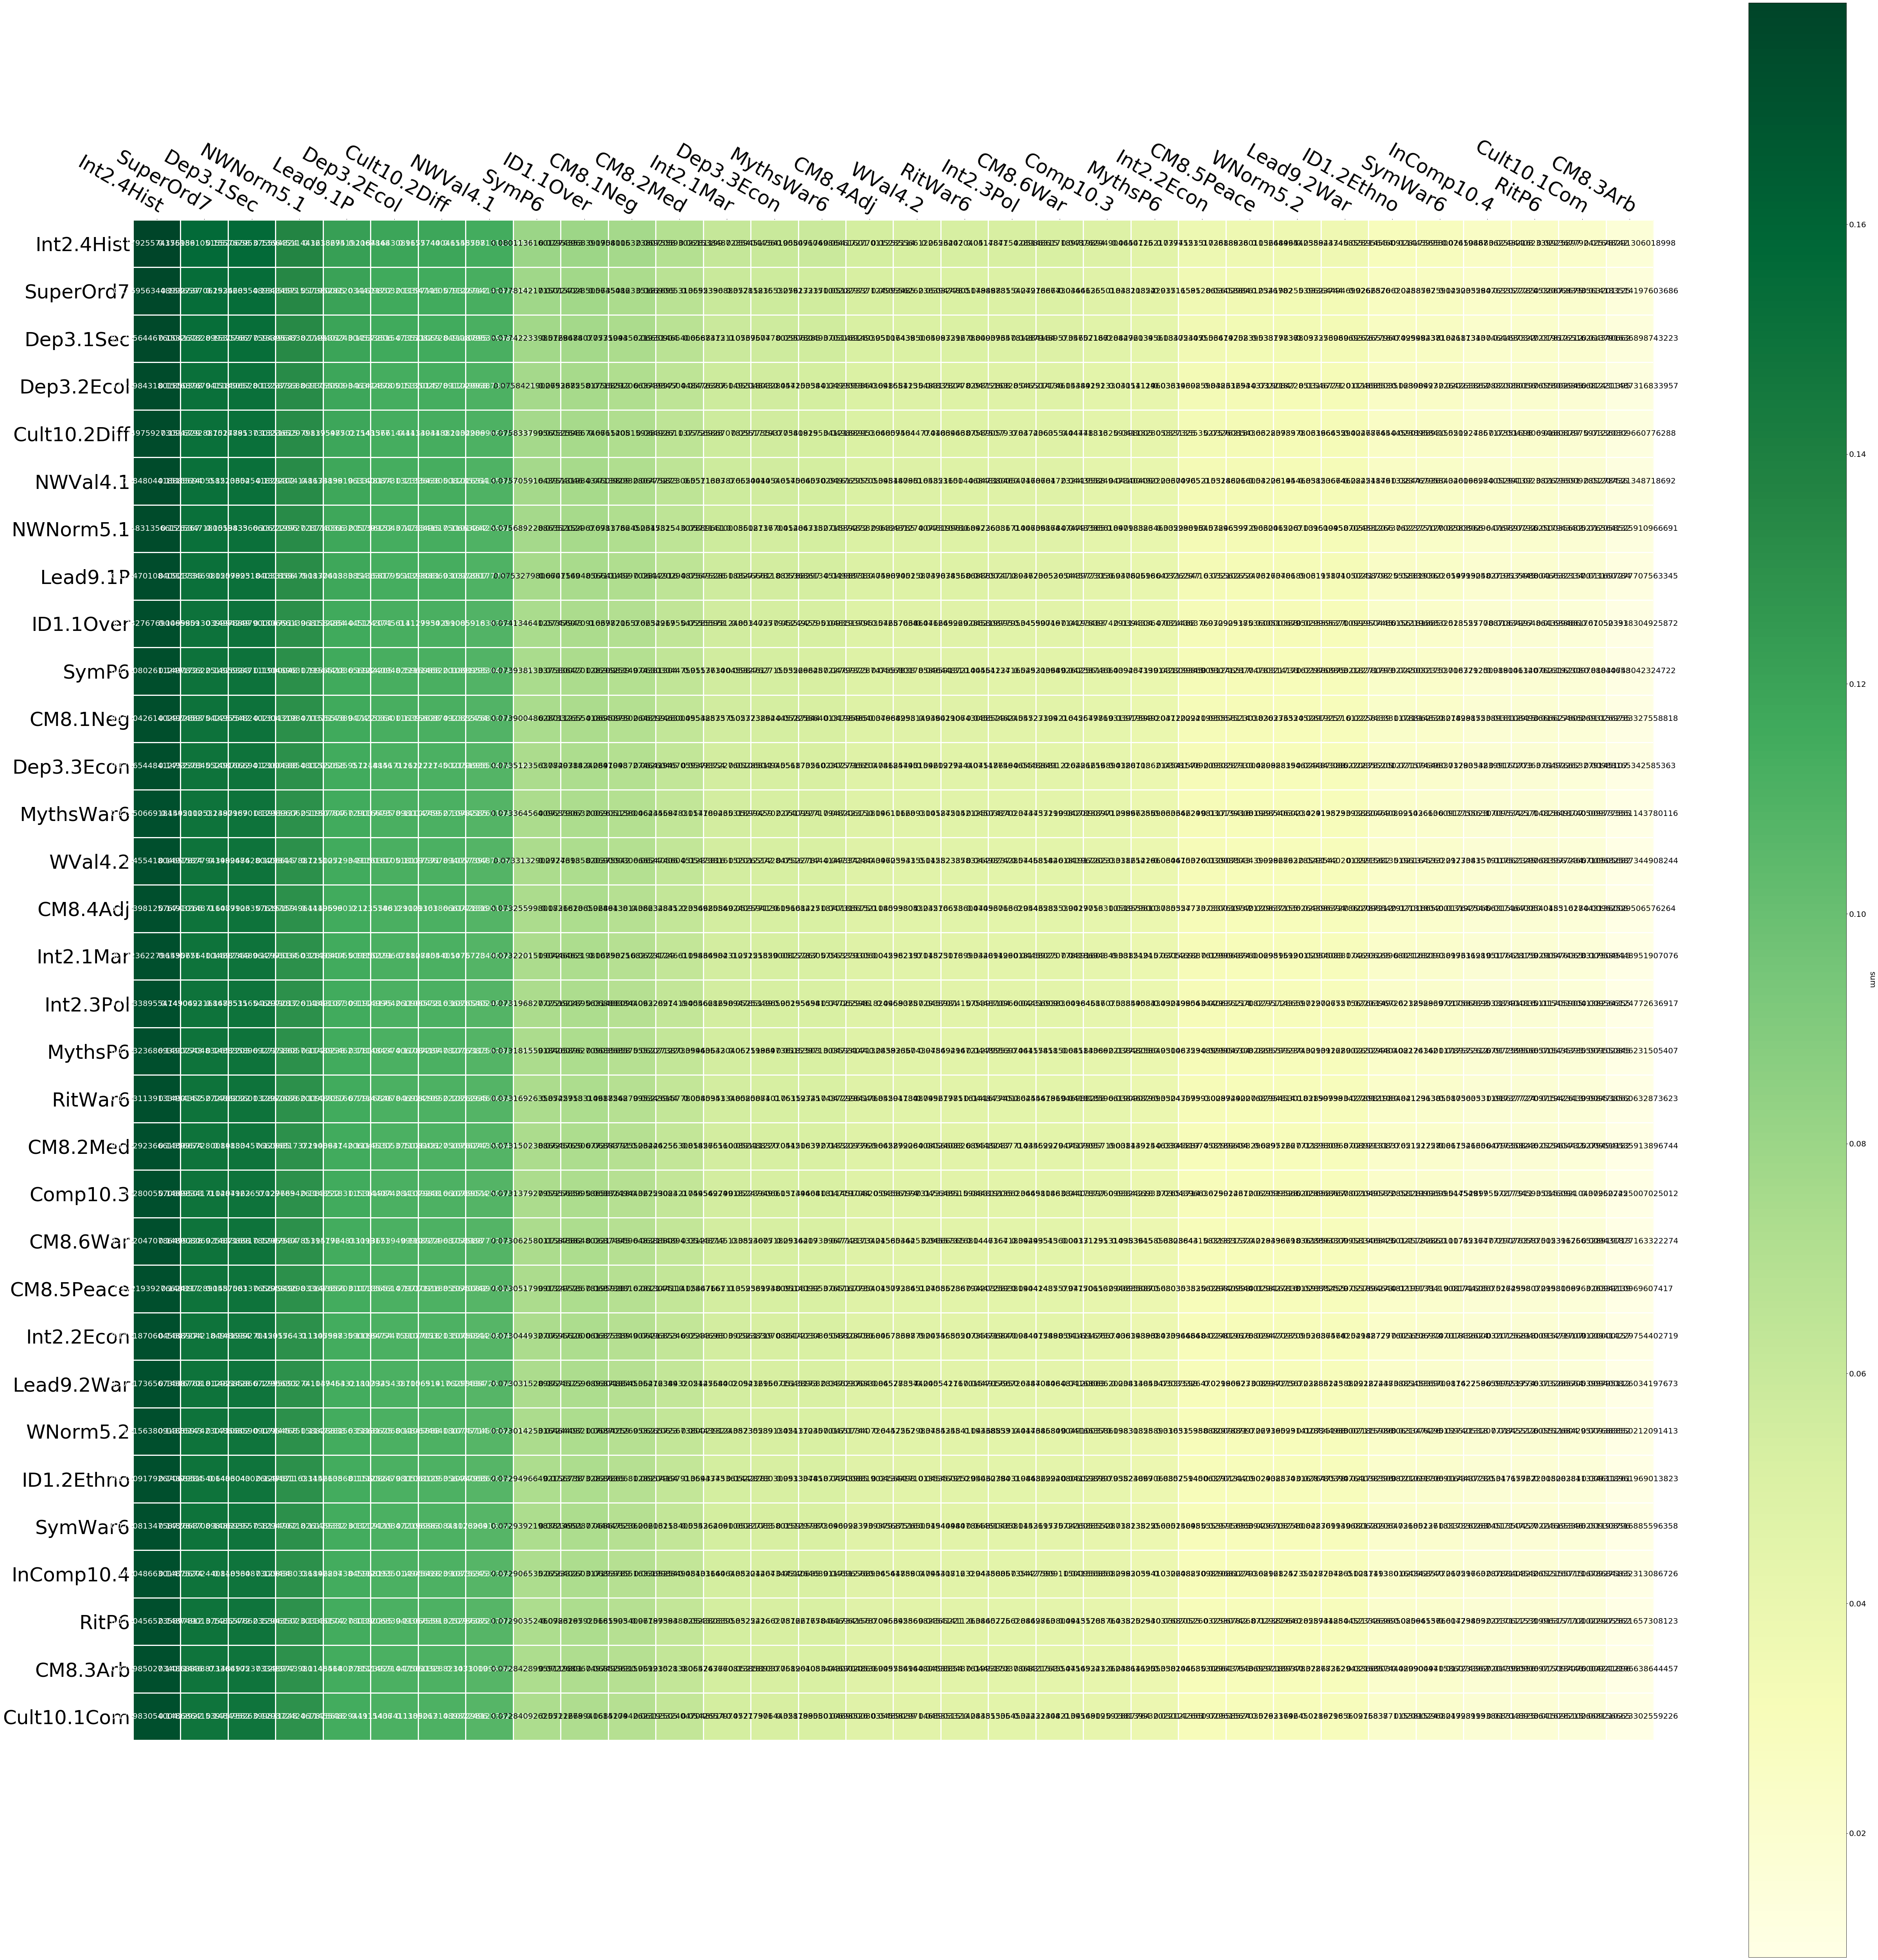

In [132]:
heatmap_data = np.zeros([32, 32])

for i in range(X.shape[1]):
    curr_y = sorted_indices_proba_product[i]
    for j in range(X.shape[1]):
        curr_x = sorted_indices_proba_sum[j]
        heatmap_data[i][j] = sum_of_probas[curr_x] + product_of_probas[curr_y]


fig, ax = plt.subplots(figsize=(70,70))

im, cbar = heatmap(heatmap_data, X.columns[sorted_indices_proba_product], X.columns[sorted_indices_proba_sum], ax=ax, cmap = "YlGn", cbarlabel="sum")

texts = annotate_heatmap(im, valfmt="{x:1}")

fig.tight_layout()
plt.tick_params(labelsize=50)
plt.show

